# 🦸‍♂️ 슈퍼히어로 팀 빌딩 - 범주형 데이터를 활용한 팀 분류 모델 구축하기
---
### 🏰 **배경 스토리:**
당신은 **슈퍼히어로 에이전시**의 데이터 분석가입니다. 에이전시에서는 슈퍼히어로들의 특성과 능력치를 기반으로 팀을 분류하려고 합니다.
당신의 임무는 **슈퍼히어로 데이터셋을 활용하여 슈퍼히어로를 특정 팀(예: 어벤져스, 저스티스 리그 등)**으로 분류하는 **딥뉴럴넷 모델을 설계하고 학습**시키는 것입니다.

### 📂 **사용 데이터셋:**
- **Superhero Dataset:**
  - 각 슈퍼히어로의 특성(예: Strength, Intelligence, Speed, Agility 등)과 팀 정보가 포함된 CSV 파일
  - 범주형 칼럼: **Team, Alignment, Gender**
  - 연속형 칼럼: **Strength, Intelligence, Speed, Durability, Power, Combat**

### 🎯 **미션 목표:**
1. **데이터 전처리:**
   - 범주형 데이터는 `nn.Embedding`을 활용하여 임베딩 벡터로 변환  
   - 연속형 데이터는 정규화 또는 표준화 적용  
   - 범주형 및 연속형 데이터를 병합하여 최종 입력 데이터셋 구성  

2. **모델 설계:**
   - 입력: 범주형 + 연속형 데이터 병합  
   - 은닉층: `nn.Linear`, `nn.ReLU`, `nn.BatchNorm1d`  
   - 출력층: 분류를 위한 `nn.Softmax` 사용  
   - 모델 구조를 텐서보드에 시각화하기  

3. **모델 학습:**
   - 학습 과정의 Loss 및 Accuracy를 텐서보드로 실시간 시각화  
   - 학습 완료 후, Confusion Matrix를 시각화하여 분류 성능 확인  

4. **결과 분석:**
   - 가장 잘 분류된 슈퍼히어로와 가장 오분류된 슈퍼히어로를 시각화하여 보고  
   - 텐서보드에서 학습 곡선과 임베딩 벡터의 시각화 비교  


🧑‍💻 실습 가이드라인:
1. 데이터셋 준비:
슈퍼히어로 데이터셋을 pandas로 로드하고, 범주형 칼럼들을 astype('category')로 변환

범주형 칼럼의 고유값 수를 기반으로 임베딩 크기 계산

2. 모델 구현:
임베딩 레이어: 각 범주형 칼럼에 대해 임베딩 벡터를 생성

연속형 데이터는 torch.tensor()로 변환하여 병합

은닉층 구성: nn.Linear, nn.ReLU, nn.BatchNorm1d, nn.Dropout

출력층: nn.Softmax로 다중 클래스 분류

3. 텐서보드 시각화:
학습 과정에서 torch.utils.tensorboard를 활용하여 Loss 및 Accuracy 시각화

Confusion Matrix 및 임베딩 벡터 시각화

In [24]:
# 데이터셋 준비
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv('/content/superhero_dataset.csv')

print("데이터 셋 정보: ")
print(df.info())

# 범주형 칼럼
categorical_columns = ['Team', 'Alignment', 'Gender']
for col in categorical_columns:
    print(f"\n{col} 고유값:")
    print(df[col].value_counts())

데이터 셋 정보: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Team          500 non-null    object
 1   Alignment     500 non-null    object
 2   Gender        500 non-null    object
 3   Strength      500 non-null    int64 
 4   Intelligence  500 non-null    int64 
 5   Speed         500 non-null    int64 
 6   Durability    500 non-null    int64 
 7   Power         500 non-null    int64 
 8   Combat        500 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 35.3+ KB
None

Team 고유값:
Team
Fantastic Four    112
Avengers          109
Justice League     95
Guardians          93
X-Men              91
Name: count, dtype: int64

Alignment 고유값:
Alignment
Good       175
Neutral    166
Evil       159
Name: count, dtype: int64

Gender 고유값:
Gender
Other     173
Male      167
Female    160
Name: count, dtype: int64


In [25]:
# 데이터 전처리
#범주형 데이터 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 연속형 데이터 정규화
continuous_columns = ['Strength', 'Intelligence', 'Speed', 'Durability', 'Power', 'Combat']
scaler = StandardScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

# 타켓 변수 설정
target_column = 'Team_encoded'

# 특성, 타겟 분리
X_categorical = df[[f'{col}_encoded' for col in categorical_columns]].values
X_continuous = df[continuous_columns].values
y = df[target_column].values

# 훈련, 테스트 분리
X_cat_train, X_cat_test, X_cont_train, X_cont_test, y_train, y_test = train_test_split(
    X_categorical, X_continuous, y, test_size=0.2, random_state=42
)

# 텐서로 변환
X_cat_train = torch.LongTensor(X_cat_train)
X_cat_test = torch.LongTensor(X_cat_test)
X_cont_train = torch.FloatTensor(X_cont_train)
X_cont_test = torch.FloatTensor(X_cont_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

#임베딩 크기 계산
embedding_sizes = [len(np.unique(df[col])) for col in categorical_columns]

In [26]:
# 모델 설계
class SuperheroClassifier(nn.Module):
    def __init__(self, categorical_embedding_sizes, num_continuous_features, num_classes):
        super().__init__()

        # 범주형 임베딩
        self.embeddings = nn.ModuleList([
            nn.Embedding(size, min(50, (size + 1) // 2))
            for size in categorical_embedding_sizes
        ])

        # 임베딩 + 연속형 특성 총 크기 계산
        total_embedding_size = sum(emb.embedding_dim for emb in self.embeddings)
        input_size = total_embedding_size + num_continuous_features

        # 신경망 레이어
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, categorical_x, continuous_x):
        # 범주형 데이터 임베딩
        embeddings = [emb(categorical_x[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embeddings, dim=1)

        # 임베딩 + 연속형 특성 결합
        x = torch.cat([embedded, continuous_x], dim=1)

        return self.network(x)

# 모델 초기화
num_classes = len(np.unique(y))
model = SuperheroClassifier(
    categorical_embedding_sizes=embedding_sizes,
    num_continuous_features=len(continuous_columns),
    num_classes=num_classes
)

In [27]:
# 모델 학습 및 평가
# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 텐서보드 writer 설정
writer = SummaryWriter('runs/superhero_classification')

# 학습 파라미터
num_epochs = 100
batch_size = 32

# 배치 생성 함수
def create_batches(X_cat, X_cont, y, batch_size):
    dataset_size = len(y)
    for i in range(0, dataset_size, batch_size):
        end = min(i + batch_size, dataset_size)
        yield (X_cat[i:end], X_cont[i:end], y[i:end])

# 학습 루프
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # 배치별 학습
    for batch_cat, batch_cont, batch_y in create_batches(X_cat_train, X_cont_train, y_train, batch_size):
        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(batch_cat, batch_cont)
        loss = criterion(outputs, batch_y)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 검증
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_cat_test, X_cont_test)
        val_loss = criterion(val_outputs, y_test)
        val_preds = torch.argmax(val_outputs, dim=1)
        accuracy = accuracy_score(y_test, val_preds)

        # 텐서보드에 기록
        writer.add_scalar('Loss/train', total_loss/len(X_cat_train), epoch)
        writer.add_scalar('Loss/validation', val_loss.item(), epoch)
        writer.add_scalar('Accuracy/validation', accuracy, epoch)

    # 최고 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_superhero_model.pth')

    # 진행 상황 출력
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], '
              f'Train Loss: {total_loss/len(X_cat_train):.4f}, '
              f'Val Loss: {val_loss.item():.4f}, '
              f'Val Accuracy: {accuracy:.4f}')

# 텐서보드 종료
writer.close()

Epoch [0/100], Train Loss: 0.0441, Val Loss: 1.2846, Val Accuracy: 0.6800
Epoch [10/100], Train Loss: 0.0079, Val Loss: 0.1869, Val Accuracy: 1.0000
Epoch [20/100], Train Loss: 0.0018, Val Loss: 0.0161, Val Accuracy: 1.0000
Epoch [30/100], Train Loss: 0.0009, Val Loss: 0.0049, Val Accuracy: 1.0000
Epoch [40/100], Train Loss: 0.0006, Val Loss: 0.0023, Val Accuracy: 1.0000
Epoch [50/100], Train Loss: 0.0004, Val Loss: 0.0013, Val Accuracy: 1.0000
Epoch [60/100], Train Loss: 0.0002, Val Loss: 0.0007, Val Accuracy: 1.0000
Epoch [70/100], Train Loss: 0.0002, Val Loss: 0.0004, Val Accuracy: 1.0000
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0003, Val Accuracy: 1.0000
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.0002, Val Accuracy: 1.0000


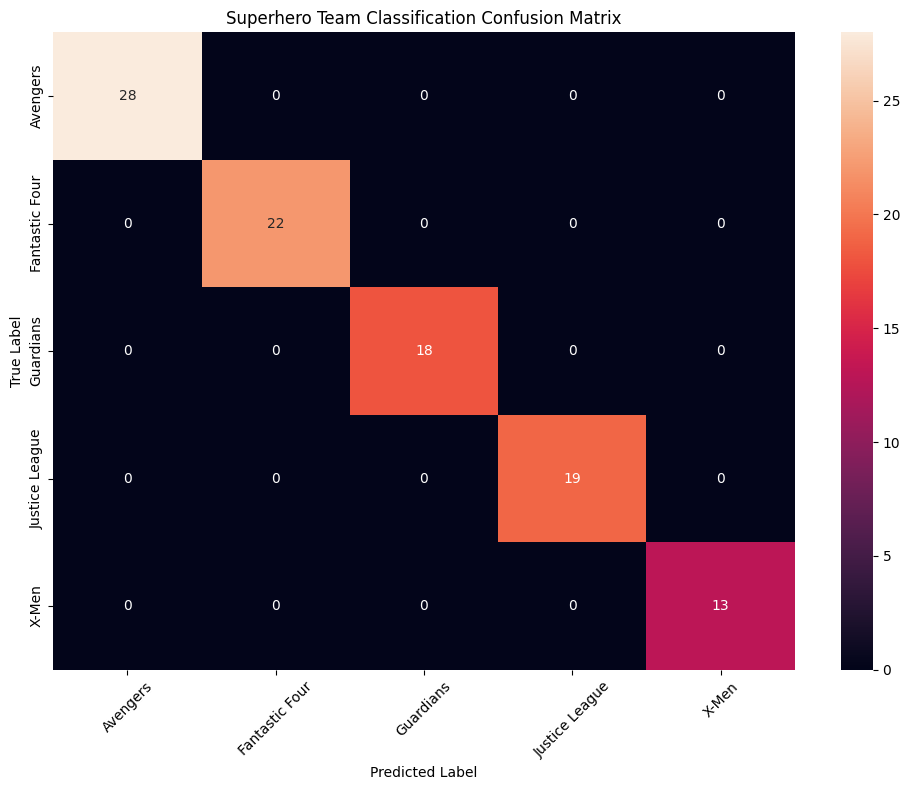

분류 리포트:
                precision    recall  f1-score   support

      Avengers       1.00      1.00      1.00        28
Fantastic Four       1.00      1.00      1.00        22
     Guardians       1.00      1.00      1.00        18
Justice League       1.00      1.00      1.00        19
         X-Men       1.00      1.00      1.00        13

      accuracy                           1.00       100
     macro avg       1.00      1.00      1.00       100
  weighted avg       1.00      1.00      1.00       100


잘못 분류된 샘플 수: 0

잘못 분류된 상위 5개 샘플:


In [29]:
# 모델 평가 및 시각화
# 최고 모델 로드
model.load_state_dict(torch.load('best_superhero_model.pth'))
model.eval()

# 최종 예측
with torch.no_grad():
    final_outputs = model(X_cat_test, X_cont_test)
    final_preds = torch.argmax(final_outputs, dim=1)

# 혼동 행렬 생성

cm = confusion_matrix(y_test, final_preds)
# 혼동 행렬 시각화
plt.figure(figsize=(10,8))
team_labels = label_encoders['Team'].classes_
sns.heatmap(cm, annot=True, fmt='d', xticklabels=team_labels, yticklabels=team_labels)
plt.title('Superhero Team Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()

# 분류 리포트
from sklearn.metrics import classification_report
print("분류 리포트:")
print(classification_report(y_test, final_preds, target_names=team_labels))

# 잘못 분류된 샘플 분석
misclassified_indices = np.where(y_test != final_preds)[0]
print("\n잘못 분류된 샘플 수:", len(misclassified_indices))

# 상위 5개 잘못 분류된 샘플 출력
print("\n잘못 분류된 상위 5개 샘플:")
for idx in misclassified_indices[:5]:
    true_team = team_labels[y_test[idx]]
    predicted_team = team_labels[final_preds[idx]]
    print(f"True Team: {true_team}, Predicted Team: {predicted_team}")

✅ 보너스 미션:
새로운 슈퍼히어로의 특성을 입력받아 팀을 예측하는 인터랙티브 입력 기능을 구현

잘못 분류된 슈퍼히어로의 특성 분석 및 해당 샘플의 임베딩 벡터 시각화

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 텐서보드 설정
writer = SummaryWriter('runs/superhero_classification')